Aperture as a thermal plate
====
Last updated: 24 Aug 2018  
  
This is a simplified heat transfer analysis of the amplifiers used in the RF front end section of the CBITS phased array.  The amplifiers generate about 0.35 Watts of heat each and there is a substantial quantity of amplifiers used in the antenna.  The heat from these components must be transfered out to the enviroment.  This analysis will calculate the surface temerature of the antenna boards under some test conditions.  

This analysis treats the amphifier boards as a verticle plate with internal source of heat.  Convection and radiation heat transfer are included.  equations and methods from Heat Tranfser, A Practical Approach, 2nd Edition, by Yunus A. Cengel were used in this analysis.  

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Power dissapated by front end RF amps

In [2]:
# L and S band amplifier bias
Vdd = 5  # volts
Idd = 0.07  # 70mA typical
pwr_TQP3M9037 = Vdd*Idd
print('power dissapated by each TQP3M9037 = {:.2f} W'.format(pwr_TQP3M9037))

# L-Band
num_ele = 140
amps_per_ele = 4
pwr_L_band_rf_amps = num_ele*amps_per_ele*pwr_TQP3M9037
print('L-Band: power used by RF front end amps = {:.1f} W'.format(pwr_L_band_rf_amps))

# S-Band
num_ele = 512
amps_per_ele = 4
pwr_S_band_rf_amps = num_ele*amps_per_ele*pwr_TQP3M9037
print('S-Band: power used by RF front end amps = {:.1f} W'.format(pwr_S_band_rf_amps))
print()

# C-Band, amp is a QPL9503, Vdd=5V, Idd=56mA
num_ele = 1536
amps_per_ele = 6
Vdd = 5  # volts
Idd = 0.056  # 56mA typical
pwr_TQP3M9503 = Vdd*Idd
print('power dissapated by each QPL9503 = {:.2f} W'.format(pwr_TQP3M9503))
pwr_C_band_rf_amps = num_ele*amps_per_ele*pwr_TQP3M9503
print('C-Band: power used by RF front end amps = {:.1f} W'.format(pwr_C_band_rf_amps))

total_pwr_rf_amps = pwr_L_band_rf_amps + pwr_S_band_rf_amps + pwr_C_band_rf_amps
print('power used by the front end RF amps = {:,.1f} W'.format(total_pwr_rf_amps))

power dissapated by each TQP3M9037 = 0.35 W
L-Band: power used by RF front end amps = 196.0 W
S-Band: power used by RF front end amps = 716.8 W

power dissapated by each QPL9503 = 0.28 W
C-Band: power used by RF front end amps = 2580.5 W
power used by the front end RF amps = 3,493.3 W


# Vertical plates with convection and radiation heat transfer at 1 ATM
Each antenna aperture is modeled as a vertical plate with convection and radiation as the heat transfer mechanisms.  The amplifier board is assumed to be internal to the antenna pannel assembly. Convection from one panel to the next is probably limited by the mechanical structure.  Never the less, the heat need to go somewhere.  The caculated surface temperature of the plate is the mide point, with higher temperatures being at the top of the aperture.  

In [3]:
# size of individual apertures, converted to m^2
# these are probably the available areas
L_band_aperture = 3340.9*0.00064516
print('area of L-Band aperture = {:,.3f} m^2'.format(L_band_aperture))
S_band_aperture = 4942.1*0.00064516
print('area of S-Band aperture = {:,.3f} m^2'.format(S_band_aperture))
C_band_aperture = 3302.4*0.00064516
print('area of C-Band aperture = {:,.3f} m^2'.format(C_band_aperture))
area = L_band_aperture+S_band_aperture+C_band_aperture
print('total area of aperture = {:,.3f} m^2'.format(area))

area of L-Band aperture = 2.155 m^2
area of S-Band aperture = 3.188 m^2
area of C-Band aperture = 2.131 m^2
total area of aperture = 7.474 m^2


### Properties of air at 1 Atm
Select data taken from Table A-15, page 874.

In [4]:
temp = np.array([-50,-40,-30,-20,-10,0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120],dtype=float)
thermal_conduc = np.array([.01979,.02057,.02134,.02211,.02288,.02364,.02401,.02439,.02476,.02514,
    .02551,.02588,.02625,.02662,.02699,.02735,.02808,.02881,.02953,.03024,.03095,.03235])
kinem_visc = np.array([.9319,1.008,1.087,1.169,1.252,1.338,1.382,1.426,1.470,1.516,1.562,1.608,
    1.655,1.702,1.750,1.798,1.896,1.995,2.097,2.201,2.306,2.522])*1e-5
Prandle_num = np.array([.7440,.7436,.7425,.7408,.7387,.7362,.7350,.7336,.7323,.7309,.7296,.7282,
    .7268,.7255,.7241,.7228,.7202,.7177,.7154,.7132,.7111,.7073])

## L-Band

In [5]:
L = 39.15*60 # length, use L as the characteristic dimension
As = L_band_aperture*2  # surface area, use both sides
Tinf = 20  # temperature of air far away
Ts = 26.45 # initial guess

# air at film temperature
Tf = (Ts+Tinf)/2

# calculate Grashof number
v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air at 1 atm, see table A-15
g = 9.81 # gravitational acceleration, m/s^2
B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
Gr = (g*B*(Ts-Tinf)*L**3)/v**2
print('Grashof number = {:.3e}'.format(Gr))

Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
Ra = Gr*Pr
print('Rayliegh number = {:.3e}'.format(Ra))

# use the complex expression for vertical plate
Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2
print('Nusselt number = {:.1f}'.format(Nu))

k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
h = (k/L)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

Q_tot = pwr_L_band_rf_amps # power dissapated by the RF amps

# radiation heat transfer
em = 0.8  # emissivity of the board
sigma = 5.67e-8  # Stefan-Boltzmann constant
Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
print('radiation heat transfer = {:.2f} W'.format(Q_rad))

Q_conv = Q_tot - Q_rad
print('convective heat transfer = {:.2f} W'.format(Q_conv))
# re-arranging Q = h*As*(Ts-Tinf)
Ts = Q_conv/(h*As) + Tinf
print('surface temperature = {:.2f} C'.format(Ts))

Grashof number = 1.116e+19
Rayliegh number = 8.135e+18
Nusselt number = 213277.0
convective heat transfer coefficient of the flow = 2.326
radiation heat transfer = 131.15 W
convective heat transfer = 64.85 W
surface temperature = 26.47 C


The python code above is converted into a function so that fsolve can be used to iterate a solution to the surface temperature.

In [6]:
def L_plate_sea_level(Ts):
    L = 39.15*60 # length, use L as the characteristic dimension
    As = L_band_aperture*2  # surface area, use both side
    Tinf = T_test # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_L_band_rf_amps # power dissapated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [7]:
T_x = np.arange(-50, 80, 10)
T_y = np.zeros(len(T_x))  # temperature, units of degrees C
for i in range(len(T_x)):
    Ts = 20
    T_test = T_x[i]
    T_y[i] = float(fsolve(L_plate_sea_level,T_x[i]+10))

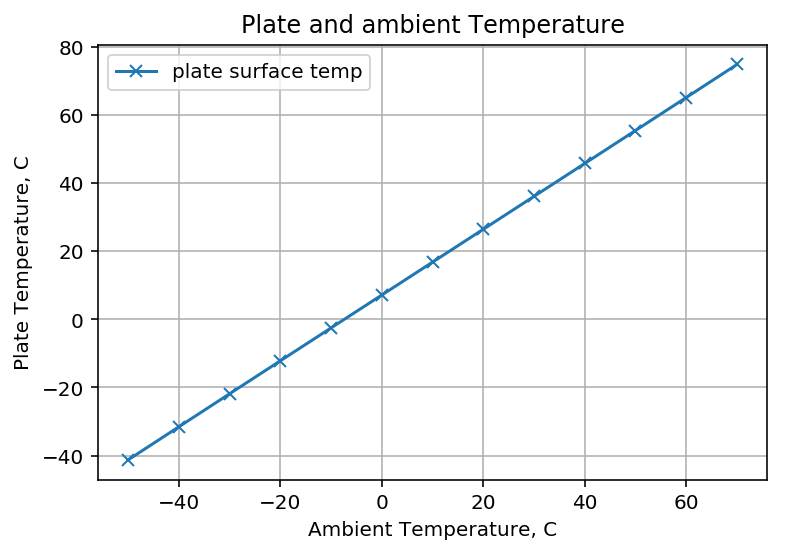

In [8]:
# plate surface temperature vs ambient temperature
plt.plot(T_x,T_y,'-x',label='plate surface temp')
plt.xlabel('Ambient Temperature, C')
plt.ylabel('Plate Temperature, C')
plt.title('Plate and ambient Temperature')
plt.legend()
plt.grid()
plt.show()

## S-Band

In [9]:
L = 39.15*60 # length, use L as the characteristic dimension
As = S_band_aperture*2  # surface area, use both sides
Tinf = 20  # temperature of air far away
Ts = 34 # initial guess

# air at film temperature
Tf = (Ts+Tinf)/2

# calculate Grashof number
v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air at 1 atm, see table A-15
g = 9.81 # gravitational acceleration, m/s^2
B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
Gr = (g*B*(Ts-Tinf)*L**3)/v**2
print('Grashof number = {:.3e}'.format(Gr))

Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
Ra = Gr*Pr
print('Rayliegh number = {:.3e}'.format(Ra))

# use the complex expression for vertical plate
Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2
print('Nusselt number = {:.1f}'.format(Nu))

k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
h = (k/L)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

Q_tot = pwr_S_band_rf_amps # power dissapated by the RF amps

# radiation heat transfer
em = .8  # emissivity of the board
sigma = 5.67e-8  # Stefan-Boltzmann constant
Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
print('radiation heat transfer = {:.2f} W'.format(Q_rad))

Q_conv = Q_tot - Q_rad
print('convective heat transfer = {:.2f} W'.format(Q_conv))
# re-arranging Q = h*As*(Ts-Tinf)
Ts = Q_conv/(h*As) + Tinf
print('surface temperature = {:.2f} C'.format(Ts))

Grashof number = 2.191e+19
Rayliegh number = 1.593e+19
Nusselt number = 266621.7
convective heat transfer coefficient of the flow = 2.971
radiation heat transfer = 437.59 W
convective heat transfer = 279.21 W
surface temperature = 34.74 C


In [10]:
def S_plate_sea_level(Ts):
    L = 39.15*60 # length, use L as the characteristic dimension
    As = S_band_aperture*2  # surface area, use both side
    Tinf = T_test # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_S_band_rf_amps # power dissapated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [11]:
T_x = np.arange(-50, 80, 10)
T_y = np.zeros(len(T_x))  # temperature, units of degrees C
for i in range(len(T_x)):
    Ts = 20
    T_test = T_x[i]
    T_y[i] = float(fsolve(S_plate_sea_level,T_x[i]+10))

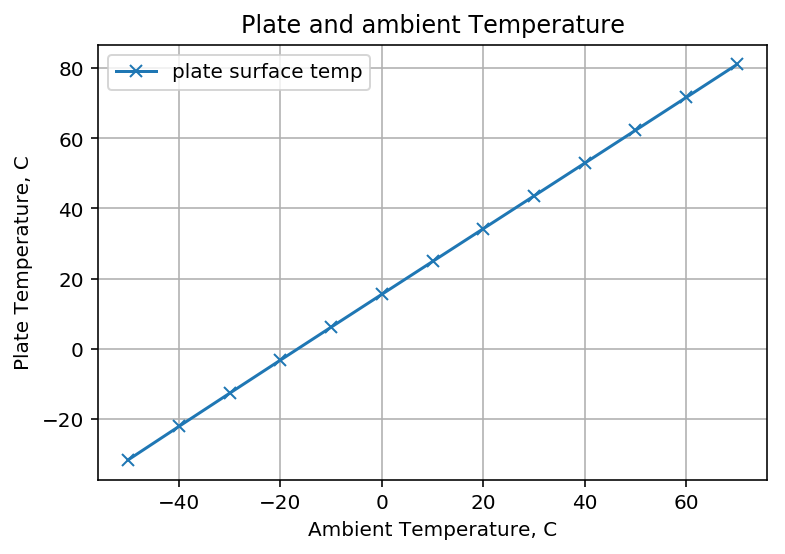

In [12]:
# plate surface temperature vs ambient temperature
plt.plot(T_x,T_y,'-x',label='plate surface temp')
plt.xlabel('Ambient Temperature, C')
plt.ylabel('Plate Temperature, C')
plt.title('Plate and ambient Temperature')
plt.legend()
plt.grid()
plt.show()

## C-Band

In [13]:
L = 39.15*60 # length, use L as the characteristic dimension
As = C_band_aperture*2  # surface area, use both sides
Tinf = 20  # temperature of air far away
Ts = 77.5 # initial guess

# air at film temperature
Tf = (Ts+Tinf)/2

# calculate Grashof number
v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air at 1 atm, see table A-15
g = 9.81 # gravitational acceleration, m/s^2
B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
Gr = (g*B*(Ts-Tinf)*L**3)/v**2
print('Grashof number = {:.3e}'.format(Gr))

Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
Ra = Gr*Pr
print('Rayliegh number = {:.3e}'.format(Ra))

# use the complex expression for veryical plate
Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2
print('Nusselt number = {:.1f}'.format(Nu))

k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
h = (k/L)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

Q_tot = pwr_C_band_rf_amps # power dissapated by the RF amps

# radiation heat transfer
em = .8  # emissivity of the board
sigma = 5.67e-8  # Stefan-Boltzmann constant
Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
print('radiation heat transfer = {:.2f} W'.format(Q_rad))

Q_conv = Q_tot - Q_rad
print('convective heat transfer = {:.2f} W'.format(Q_conv))
# re-arranging Q = h*As*(Ts-Tinf)
Ts = Q_conv/(h*As) + Tinf
print('surface temperature = {:.2f} C'.format(Ts))

Grashof number = 5.295e+19
Rayliegh number = 3.791e+19
Nusselt number = 354999.6
convective heat transfer coefficient of the flow = 4.436
radiation heat transfer = 1492.58 W
convective heat transfer = 1087.90 W
surface temperature = 77.56 C


In [14]:
def C_plate_sea_level(Ts):
    L = 39.15*60 # length, use L as the characteristic dimension
    As = C_band_aperture*2  # surface area, use both side
    Tinf = T_test # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_C_band_rf_amps # power dissapated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [15]:
T_x = np.arange(-50, 80, 10)
T_y = np.zeros(len(T_x))  # temperature, units of degrees C
for i in range(len(T_x)):
    Ts = 20
    T_test = T_x[i]
    T_y[i] = float(fsolve(C_plate_sea_level,T_x[i]+10))

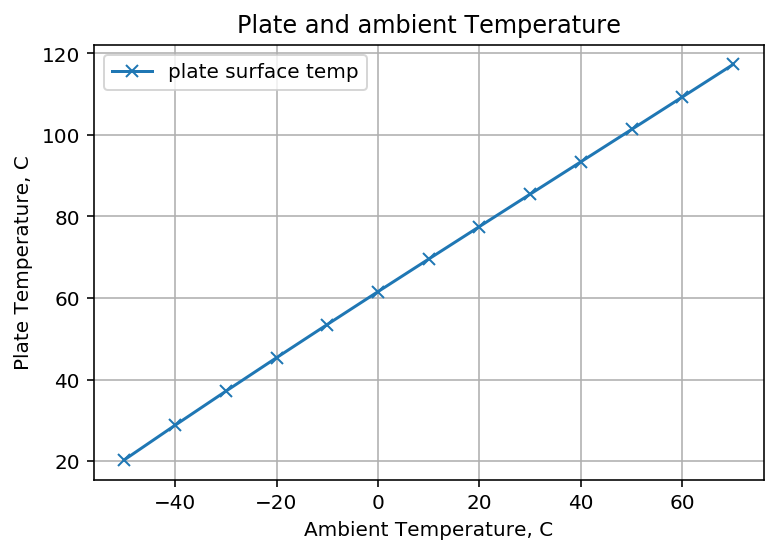

In [16]:
# plate surface temperature vs ambient temperature
plt.plot(T_x,T_y,'-x',label='plate surface temp')
plt.xlabel('Ambient Temperature, C')
plt.ylabel('Plate Temperature, C')
plt.title('Plate and ambient Temperature')
plt.legend()
plt.grid()
plt.show()

# Vertical plates with convection and radiation heat transfer vs altitude
These properties of air are scaled with altitude.  
v' = v/Pressure  
k' = k x Pressure  
  
Altitudes of interest is 0 to 45kft (13716 m).  

In [17]:
alt = np.linspace(0, 50000, num=30, endpoint=True)
T = np.zeros(len(alt))  # temperature, units of degrees C
rho = np.zeros(len(alt))   # pressure as a function of temperature, units of kPa

# calculate the pressure and temperature as a function of altitude
for i in range(len(alt)):
    if alt[i] <= 11000:  # The troposphere runs from the surface of the Earth to 11,000 meters.
        T[i] =  15.04 - .00649 * alt[i]
        rho[i] = 101.29 * ((T[i] + 273.1)/288.08)**5.256
    if (alt[i] > 11000) and (alt[i] <= 25000): #The lower stratosphere runs from 11,000 meters to 25,000 meters
        T[i] = -56.46  # a constant
        rho[i] = 22.65 * np.exp(1.73 - .000157 * alt[i])
    if alt[i] > 25000:  # The upper stratosphere model is used for altitudes above 25,000 meters.
        T[i] = -131.21 + 0.00299 * alt[i]
        rho[i] = 2.488 * ((T[i] + 273.1)/ 216.6)**-11.388

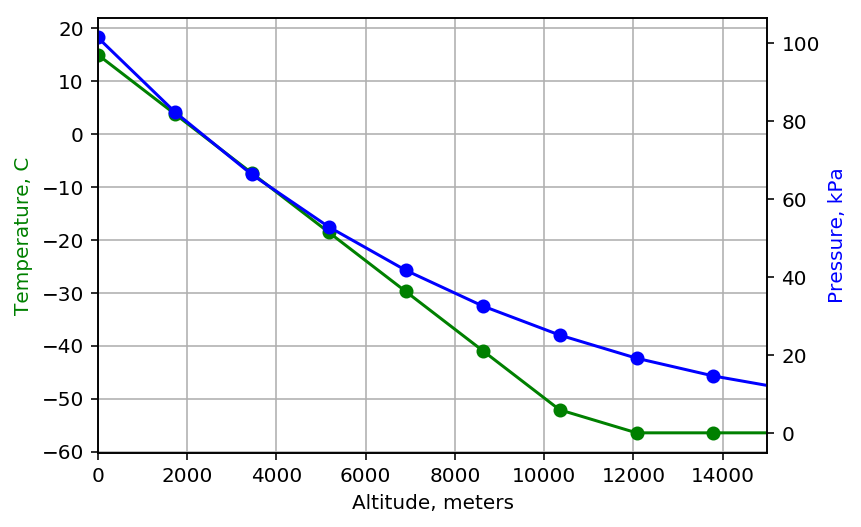

In [18]:
# plot the temperature and pressure vs altitude
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(alt, T,'g-o')
ax2.plot(alt, rho,'b-o')
ax1.set_xlabel('Altitude, meters')
ax1.set_ylabel('Temperature, C', color='g')
ax2.set_ylabel('Pressure, kPa', color='b')
ax1.grid()  # put grid marks on temperature axis
plt.xlim(0,15000)
plt.show()

## L-Band

In [19]:
elevation = 0

L = 39.15*60 # length, use L as the characteristic dimension
As = L_band_aperture*2  # surface area, use both sides
Tinf = np.interp(elevation,alt,T) # temperature of air far away
print('Tinf = {:f}'.format(Tinf))
Ts = 40 # initial guess

# air at film temperature
Tf = (Ts+Tinf)/2

# calculate Grashof number
atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
print('atm = {:.3f}'.format(atm))
v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
print('kinematic viscosity = {:.3e}'.format(v))

g = 9.81 # gravitational acceleration, m/s^2
B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
Gr = (g*B*(Ts-Tinf)*L**3)/v**2
print('Grashof number = {:.3e}'.format(Gr))

Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
Ra = Gr*Pr
print('Rayliegh number = {:.3e}'.format(Ra))

# use the complex expression for vertical plate
Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2
print('Nusselt number = {:.1f}'.format(Nu))

k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
h = (k/L)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

Q_tot = pwr_L_band_rf_amps # power dissapated by the RF amps

# radiation heat transfer
em = .8  # emissivity of the board
sigma = 5.67e-8  # Stefan-Boltzmann constant
Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
print('radiation heat transfer = {:.2f} W'.format(Q_rad))

Q_conv = Q_tot - Q_rad
print('convective heat transfer = {:.2f} W'.format(Q_conv))
# re-arranging Q = h*As*(Ts-Tinf)
Ts = Q_conv/(h*As) + Tinf
print('surface temperature = {:.2f} C'.format(Ts))

Tinf = 15.040000
atm = 1.001
kinematic viscosity = 1.701e-05
Grashof number = 3.651e+19
Rayliegh number = 2.649e+19
Nusselt number = 315676.7
convective heat transfer coefficient of the flow = 3.577
radiation heat transfer = 530.77 W
convective heat transfer = -334.77 W
surface temperature = -6.67 C


In [20]:
def L_plate(Ts):
    L = 39.15*60 # length, use L as the characteristic dimension
    As = L_band_aperture*2  # surface area, use both side
    Tinf = np.interp(elevation,alt,T) # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
    v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc)*atm # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_L_band_rf_amps # power dissapated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [21]:
ele_x = np.arange(0, 16.1e3, 1000)
T_y = np.zeros(len(ele_x))  # temperature, units of degrees C
for i in range(len(ele_x)):
    elevation = ele_x[i]
    T_y[i] = float(fsolve(L_plate,np.interp(elevation,alt,T)+10))

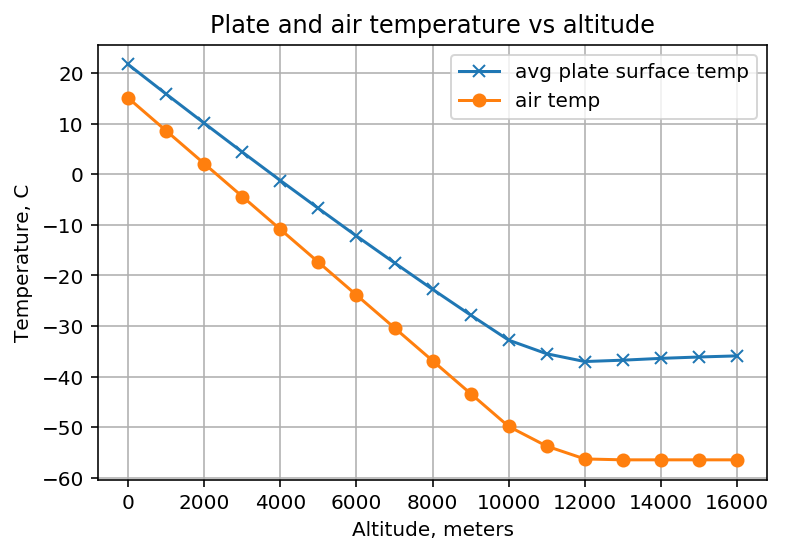

In [22]:
# plate surface temperature vs altitude
T_amb = np.interp(ele_x,alt,T) # temperature of air far away

plt.plot(ele_x,T_y,'-x',label='avg plate surface temp')
plt.plot(ele_x,T_amb,'-o',label='air temp')
plt.xlabel('Altitude, meters')
plt.ylabel('Temperature, C')
plt.title('Plate and air temperature vs altitude')
plt.legend()
plt.grid()
plt.show()

## S-Band

In [23]:
elevation = 0

L = 39.15*60 # length, use L as the characteristic dimension
As = S_band_aperture*2  # surface area, use both sides
Tinf = np.interp(elevation,alt,T) # temperature of air far away
print('Tinf = {:f}'.format(Tinf))
Ts = 30 # initial guess

# air at film temperature
Tf = (Ts+Tinf)/2

# calculate Grashof number
atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
print('atm = {:.3f}'.format(atm))
v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
print('kinematic viscosity = {:.3e}'.format(v))

g = 9.81 # gravitational acceleration, m/s^2
B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
Gr = (g*B*(Ts-Tinf)*L**3)/v**2
print('Grashof number = {:.3e}'.format(Gr))

Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
Ra = Gr*Pr
print('Rayliegh number = {:.3e}'.format(Ra))

# use the complex expression for vertical plate
Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2
print('Nusselt number = {:.1f}'.format(Nu))

k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
h = (k/L)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

Q_tot = pwr_S_band_rf_amps # power dissapated by the RF amps

# radiation heat transfer
em = .8  # emissivity of the board
sigma = 5.67e-8  # Stefan-Boltzmann constant
Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
print('radiation heat transfer = {:.2f} W'.format(Q_rad))

Q_conv = Q_tot - Q_rad
print('convective heat transfer = {:.2f} W'.format(Q_conv))
# re-arranging Q = h*As*(Ts-Tinf)
Ts = Q_conv/(h*As) + Tinf
print('surface temperature = {:.2f} C'.format(Ts))

Tinf = 15.040000
atm = 1.001
kinematic viscosity = 1.607e-05
Grashof number = 2.493e+19
Rayliegh number = 1.815e+19
Nusselt number = 278532.4
convective heat transfer coefficient of the flow = 3.069
radiation heat transfer = 447.00 W
convective heat transfer = 269.80 W
surface temperature = 28.83 C


In [24]:
def S_plate(Ts):
    L = 39.15*60 # length, use L as the characteristic dimension
    As = S_band_aperture*2  # surface area, use both side
    Tinf = np.interp(elevation,alt,T) # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
    v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc)*atm # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_S_band_rf_amps # power dissapated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [25]:
ele_x = np.arange(0, 16.1e3, 1000)
T_y = np.zeros(len(ele_x))  # temperature, units of degrees C
for i in range(len(ele_x)):
    elevation = ele_x[i]
    T_y[i] = float(fsolve(S_plate,np.interp(elevation,alt,T)+10))

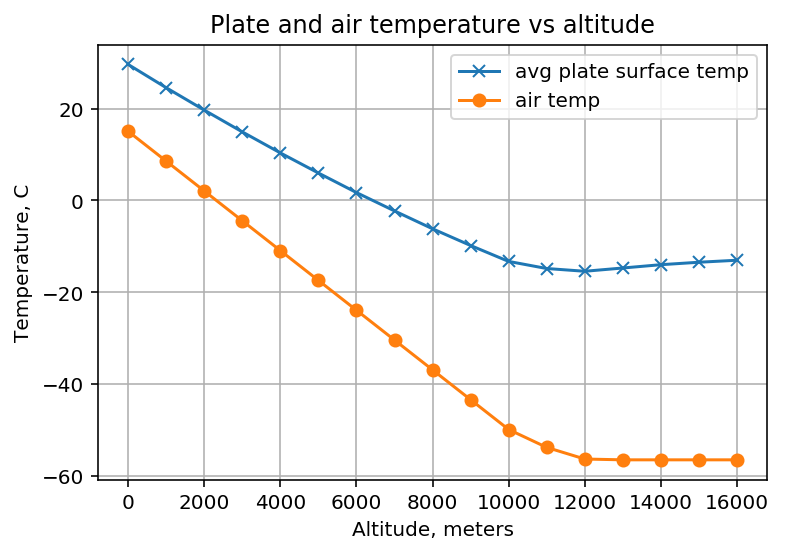

In [26]:
# plate surface temperature vs altitude
T_amb = np.interp(ele_x,alt,T) # temperature of air far away

plt.plot(ele_x,T_y,'-x',label='avg plate surface temp')
plt.plot(ele_x,T_amb,'-o',label='air temp')
plt.xlabel('Altitude, meters')
plt.ylabel('Temperature, C')
plt.title('Plate and air temperature vs altitude')
plt.legend()
plt.grid()
plt.show()

## C-Band

In [27]:
elevation = 0

L = 39.15*60 # length, use L as the characteristic dimension
As = C_band_aperture*2  # surface area, use both sides
Tinf = np.interp(elevation,alt,T) # temperature of air far away
print('Tinf = {:f}'.format(Tinf))
Ts = 73 # initial guess

# air at film temperature
Tf = (Ts+Tinf)/2

# calculate Grashof number
atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
print('atm = {:.3f}'.format(atm))
v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
print('kinematic viscosity = {:.3e}'.format(v))

g = 9.81 # gravitational acceleration, m/s^2
B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
Gr = (g*B*(Ts-Tinf)*L**3)/v**2
print('Grashof number = {:.3e}'.format(Gr))

Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
Ra = Gr*Pr
print('Rayliegh number = {:.3e}'.format(Ra))

# use the complex expression for vertical plate
Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2
print('Nusselt number = {:.1f}'.format(Nu))

k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
h = (k/L)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

Q_tot = pwr_C_band_rf_amps # power dissapated by the RF amps

# radiation heat transfer
em = .8  # emissivity of the board
sigma = 5.67e-8  # Stefan-Boltzmann constant
Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
print('radiation heat transfer = {:.2f} W'.format(Q_rad))

Q_conv = Q_tot - Q_rad
print('convective heat transfer = {:.2f} W'.format(Q_conv))
# re-arranging Q = h*As*(Ts-Tinf)
Ts = Q_conv/(h*As) + Tinf
print('surface temperature = {:.2f} C'.format(Ts))

Tinf = 15.040000
atm = 1.001
kinematic viscosity = 2.024e-05
Grashof number = 5.674e+19
Rayliegh number = 4.068e+19
Nusselt number = 363511.5
convective heat transfer coefficient of the flow = 4.492
radiation heat transfer = 1439.67 W
convective heat transfer = 1140.81 W
surface temperature = 74.64 C


In [28]:
def C_plate(Ts):
    L = 39.15*60 # length, use L as the characteristic dimension
    As = C_band_aperture*2  # surface area, use both side
    Tinf = np.interp(elevation,alt,T) # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
    v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, around 0.71 for air and many other gases, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc)*atm # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_C_band_rf_amps # power dissapated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [29]:
ele_x = np.arange(0, 16.1e3, 1000)
T_y = np.zeros(len(ele_x))  # temperature, units of degrees C
for i in range(len(ele_x)):
    elevation = ele_x[i]
    T_y[i] = float(fsolve(C_plate,np.interp(elevation,alt,T)+10))

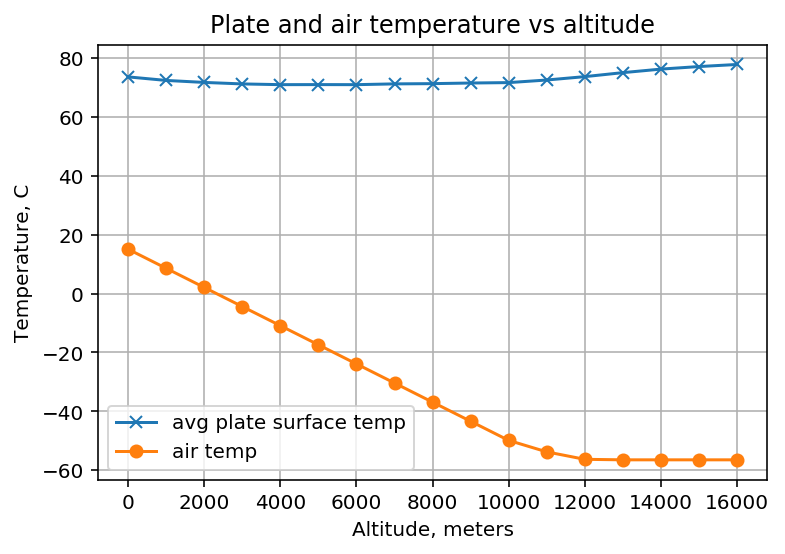

In [30]:
# plate surface temperature vs altitude
T_amb = np.interp(ele_x,alt,T) # temperature of air far away

plt.plot(ele_x,T_y,'-x',label='avg plate surface temp')
plt.plot(ele_x,T_amb,'-o',label='air temp')
plt.xlabel('Altitude, meters')
plt.ylabel('Temperature, C')
plt.title('Plate and air temperature vs altitude')
plt.legend()
plt.grid()
plt.show()

## investigate scaling k by atm

In [31]:
ele_x = np.arange(0, 16.1e3, 1000)
k_y = np.zeros(len(ele_x))  # thermal conductivity of air
for i in range(len(ele_x)):
    T_ele = np.interp(ele_x[i],alt,T) # temperature of air far away
    k_y[i] = np.interp(T_ele,temp,thermal_conduc)


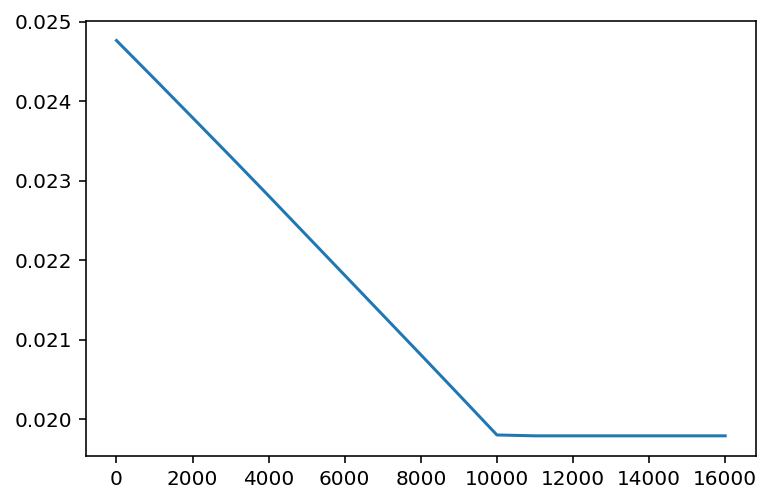

In [32]:
# plot k vs elevation
plt.plot(ele_x,k_y)
plt.show()

In [33]:
T_x = np.arange(-50, 121, 1)
k_y = np.zeros(len(T_x))  # thermal conductivity of air
for i in range(len(T_x)):
    k_y[i] = np.interp(T_x[i],temp,thermal_conduc)

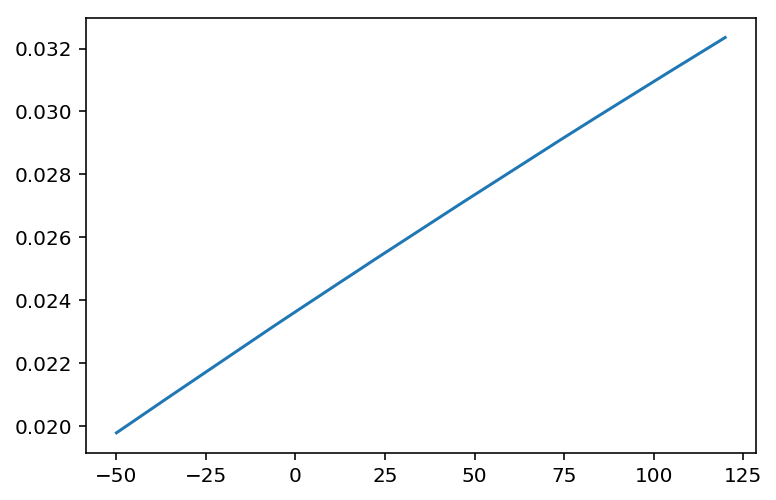

In [34]:
# plot k vs temp
plt.plot(T_x,k_y)
plt.show()

In [35]:
ele_x = np.arange(0, 16.1e3, 1000)
k_y = np.zeros(len(ele_x))  # thermal conductivity of air
atm_y = np.zeros(len(ele_x)) # atm
for i in range(len(ele_x)):
    T_ele = np.interp(ele_x[i],alt,T) # temperature of air far away
    atm_y[i] = np.interp(ele_x[i],alt,rho)*0.00986923  # convert to atm
    k_y[i] = np.interp(T_ele,temp,thermal_conduc)

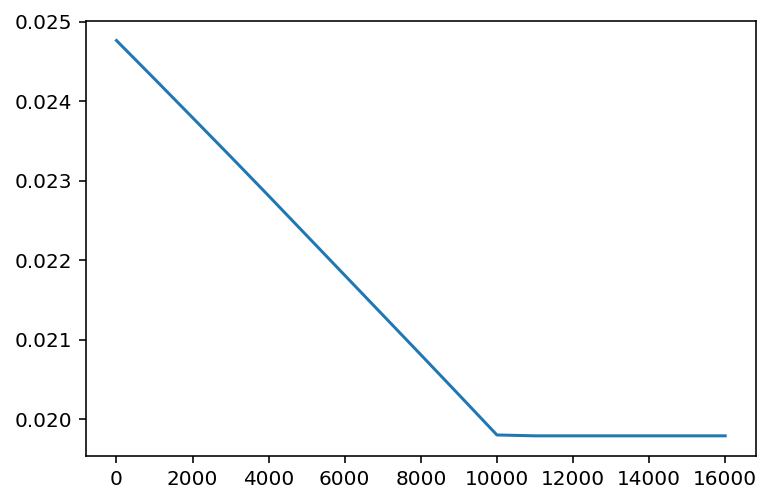

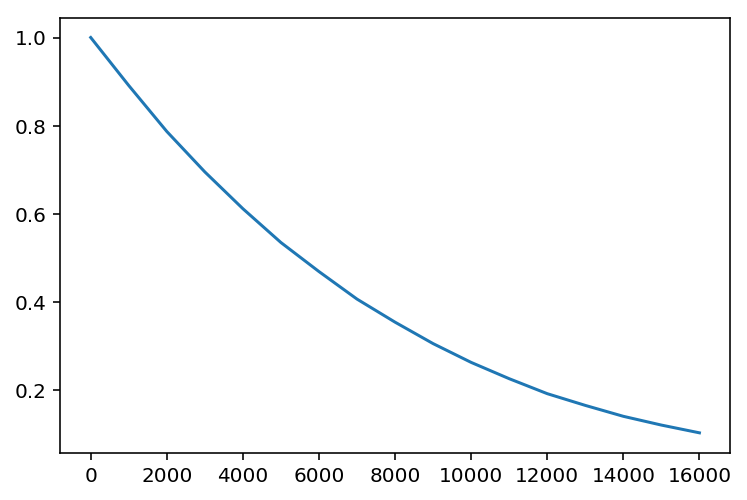

In [36]:
# plot k vs elevation
plt.plot(ele_x,k_y)
plt.show()
plt.plot(ele_x,atm_y)
plt.show()

In [37]:
ele_x = np.arange(0, 16.1e3, 1000)
k_y = np.zeros(len(ele_x))  # thermal conductivity of air
atm_y = np.zeros(len(ele_x)) # atm
for i in range(len(ele_x)):
    T_ele = np.interp(ele_x[i],alt,T) # temperature of air far away
    atm_y[i] = np.interp(ele_x[i],alt,rho)*0.00986923  # convert to atm
    k_y[i] = np.interp(T_ele,temp,thermal_conduc)*atm_y[i]

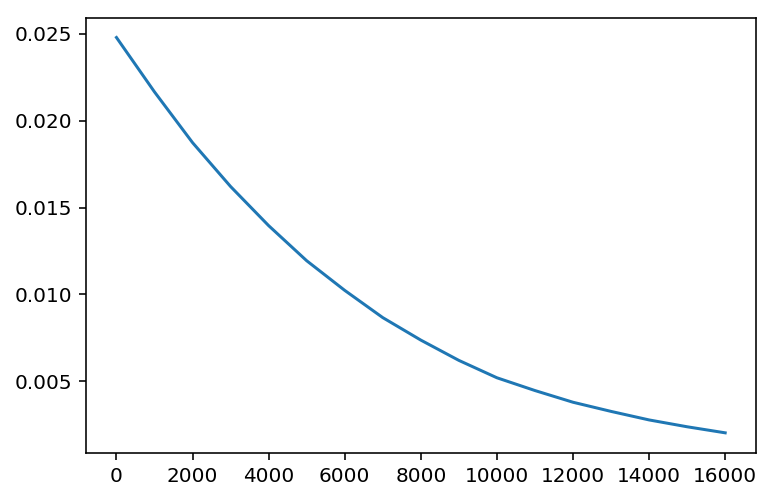

In [38]:
# plot k vs elevation
plt.plot(ele_x,k_y)
plt.show()

# old code

### Analyze total power and total area as a plate with forced air flow

In [0]:
# overall size of the aperture
length = 256.5
height = 60.8
area = length*height
#areas of small triangles
a1 = 39.15*12.03/2
a2 = 39.15*10.3/2
a3 = 62.75*12.03/2
a4 = 62.75*10.3/2
area = area - (a1 + a2 + a3 + a4)  # in^2
print('total area of aperture = {:,.2f} in^2'.format(area))
area = area*0.00064516 # convert to m^2
print('total area of aperture = {:.3f} m^2'.format(area))

In [0]:
# analyze antenna as a plate with height of 60 inches for air at 1 atm, 20C
height = 39.15*60  # analyze along heigh deminsion, convert to m
air_vel = 4  # allow a bit of air flow, m/s
print('air velocity = {:.0f} m/s'.format(air_vel))
Tair = 20  # temperature of air

# calculate Reynolds number
v = 1.516e-5  # kinematic viscosity  for air at 1 atm, 20C
Re = air_vel*height/v # Reynolds at end of the plate
print('Reynolds at end of plate = {:.3e}'.format(Re))

Pr = 0.7309  # Prandtl number for air at 1 atm, 20C

# Nusselt number for turbulant flow, disreguarding laminar flow because of the long dimension
Nu = (0.0295*Re**0.8)*Pr**(1/3)  # see page 373 for this equation
print('Nusselt number = {:.1f}'.format(Nu))

k = 0.02514  # thermal conductivity for air at 1 atm, 20C
h = (k/height)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

As = area*2  # surface area, times 2 to used both sides of the plate
Q = 3493 # thermal load from above, watts

# re-arranging Q = h*As*(Ts-Tair)
Ts = Q/(h*As) + Tair
print('surface temperature = {:.1f} C'.format(Ts))

In [0]:
# size of individual apertures, converted to m^2
# these are probably the available areas
L_band_aperture = 3340.9*0.00064516
S_band_aperture = 4942.1*0.00064516
C_band_aperture = 3302.4*0.00064516
area = L_band_aperture+S_band_aperture+C_band_aperture
print('total area of aperture = {:,.3f} m^2'.format(area))

In [0]:
Tinf = np.interp(elevation,alt,T) # temperature of air far away
print('Tinf = {:f}'.format(Tinf))
atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
print('atm = {:.3f}'.format(atm))
print('Grashof number = {:.3e}'.format(Gr))
print('Rayliegh number = {:.3e}'.format(Ra))
print('Nusselt number = {:.1f}'.format(Nu))
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))
print('radiation heat transfer = {:.2f} W'.format(Q_rad))
print('convective heat transfer = {:.2f} W'.format(Q_conv))
print('surface temperature = {:.2f} C'.format(Ts))